In [1]:
num_trials = 8
using SharedArrays
using Distributed
addprocs(num_trials)

@everywhere using PyCall
@everywhere using Random

8-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8
 9

In [53]:
@everywhere include("seajul.jl")
@time begin

epochs = 1000
T = Float64

env_name = "HalfCheetah-v2"
gym = pyimport("gym")
pyimport("pybullet_envs")
env = gym.make(env_name)
in_size = env.observation_space.shape[1]
out_size = env.action_space.shape[1]
 

Wa = SharedArray{T}(num_trials, out_size, in_size)
ra = SharedArray{T}(num_trials, epochs)

@sync @distributed for i in 1:num_trials
    seed = rand(1:2^16)
    Random.seed!(seed)
    gym = pyimport("gym")
    pyimport("pybullet_envs")
    env = gym.make(env_name)

    W = zeros(T, out_size, in_size)
    W,rews,μ,sig = SJ.ars_v2t!(env,W,epochs,T=T)
    Wa[i,:,:] = W 
    ra[i,:] = rews

end
end

CompositeException: SYSTEM: show(lasterr) caused an error

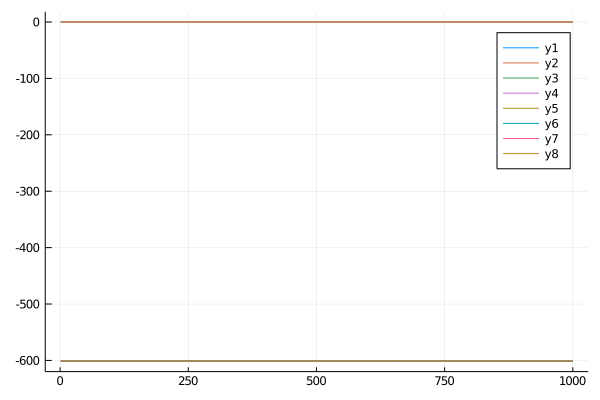

In [55]:
using Plots

plot()
for i in 1:num_trials
    plot!(ra[i,:])
end
plot!()

In [8]:
function do_rollout_eval(env::PyObject, W)
    x = env.reset()
    done = false
    reward = 0.0

    x_hist = zeros(env.observation_space.shape[1],env._max_episode_steps)
    i = 1

    act_low = convert(Array{Float64,1}, env.action_space.low)
    act_high = convert(Array{Float64,1}, env.action_space.high)

    while !done
        x_hist[:,i] = copy(x); i+=1
        print(W*x)
        u = clamp(W*x, act_low, act_high)
        x, r, done, _ = env.step(u)
        reward += r
    end
    #println(vec(mean(x_hist[:,1:i-1],dims=2)))
    return reward::Float64, x_hist
end


do_rollout_eval (generic function with 1 method)

In [9]:
r,x = do_rollout_eval(env,W)

MethodError: MethodError: no method matching *(::Tuple{Array{Float64,1},Array{Float64,2}}, ::Array{Float32,1})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  *(!Matched::PyObject, ::Any) at /home/sgillen/.julia/packages/PyCall/zqDXB/src/pyoperators.jl:13
  *(!Matched::LinearAlgebra.Adjoint{#s662,#s661} where #s661<:Union{DenseArray{T,2}, Base.ReinterpretArray{T,2,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, Base.ReshapedArray{T,2,A,MI} where MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{Base.ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, SubArray{T,2,A,I,L} where L where I<:Tuple{Vararg{Union{Int64, AbstractRange{Int64}, Base.AbstractCartesianIndex},N} where N} where A<:Union{Base.ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, Base.ReshapedArray{T,N,A,MI} where MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{Base.ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, DenseArray}} where #s662, ::Union{DenseArray{S,1}, Base.ReinterpretArray{S,1,S1,A} where S1 where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, Base.ReshapedArray{S,1,A,MI} where MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{Base.ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, SubArray{S,1,A,I,L} where L where I<:Tuple{Vararg{Union{Int64, AbstractRange{Int64}, Base.AbstractCartesianIndex},N} where N} where A<:Union{Base.ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, Base.ReshapedArray{T,N,A,MI} where MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{Base.ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, DenseArray}}) where {T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64}, S} at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/LinearAlgebra/src/matmul.jl:106
  ...

In [15]:
function f(arr, T)
    a = Array{T,5}
    for i in  1:5
        a[1] = sum(arr)
    end

    return a

end

f (generic function with 1 method)

In [17]:
@code_llvm f(zeros(4,4), Float32)


;  @ In[15]:2 within `f'
; Function Attrs: noreturn
define nonnull %jl_value_t addrspace(10)* @japi1_f_18209(%jl_value_t addrspace(10)*, %jl_value_t addrspace(10)**, i32) #0 {
top:
  %3 = alloca %jl_value_t addrspace(10)*, i32 3
  %gcframe = alloca %jl_value_t addrspace(10)*, i32 3, align 16
  %4 = bitcast %jl_value_t addrspace(10)** %gcframe to i8*
  call void @llvm.memset.p0i8.i32(i8* align 16 %4, i8 0, i32 24, i1 false)
  %5 = alloca %jl_value_t addrspace(10)**, align 8
  store volatile %jl_value_t addrspace(10)** %1, %jl_value_t addrspace(10)*** %5, align 8
  %thread_ptr = call i8* asm "movq %fs:0, $0", "=r"()
  %ptls_i8 = getelementptr i8, i8* %thread_ptr, i64 -15712
  %ptls = bitcast i8* %ptls_i8 to %jl_value_t***
  %6 = getelementptr %jl_value_t addrspace(10)*, %jl_value_t addrspace(10)** %gcframe, i32 0
  %7 = bitcast %jl_value_t addrspace(10)** %6 to i64*
  store i64 4, i64* %7
  %8 = getelementptr %jl_value_t**, %jl_value_t*** %ptls, i32 0
  %9 = getelementptr %jl_value_t ad